In [24]:
from Main import create_maze
from World import World_Class
import random
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm



In [25]:
grid_shape = (4,4)
world_instance = World_Class(create_maze())
state_dict = world_instance.value_iterations(1000, [900])
end_states = ["0_0", "3_3"]

def optimal_policy(deterministic):
    world_instance = World_Class(create_maze(deterministic=deterministic))
    world = world_instance.value_iterations(1000, [1001])
    policy = {}
    for key, value in world.items():
        x, y = key.split("_")
        actions = [("Left", world.get(f"{int(x)-1}_{y}")), ("Right", world.get(f"{int(x)+1}_{y}")), 
                   ("Up", world.get(f"{x}_{int(y)+1}")), ("Down", world.get(f"{x}_{int(y)-1}"))]
        actions = [a for a in actions if a[1] is not None]
        policy[key] = max(actions, key=lambda a: a[1].value + a[1].tran_val)[0]
    return policy

optimal_policy_determ = optimal_policy(True)
optimal_policy_not_determ = optimal_policy(False)
optimal_as_numpy = []
for key, value in optimal_policy_not_determ.items():
    if key not in end_states:
        optimal_as_numpy.append([key.split("_")[0], key.split("_")[1], value])

optimal_as_numpy = pd.DataFrame(optimal_as_numpy, columns=["x", "y", "action"]).sort_values(by=["x", "y"]).values
print(optimal_policy_determ)
print(optimal_policy_not_determ)

{'0_0': 'Up', '1_0': 'Up', '2_0': 'Up', '3_0': 'Left', '0_1': 'Right', '1_1': 'Up', '2_1': 'Left', '3_1': 'Left', '0_2': 'Right', '1_2': 'Up', '2_2': 'Up', '3_2': 'Up', '0_3': 'Right', '1_3': 'Right', '2_3': 'Right', '3_3': 'Left'}
{'0_0': 'Up', '1_0': 'Up', '2_0': 'Up', '3_0': 'Up', '0_1': 'Up', '1_1': 'Up', '2_1': 'Left', '3_1': 'Up', '0_2': 'Up', '1_2': 'Up', '2_2': 'Up', '3_2': 'Up', '0_3': 'Right', '1_3': 'Right', '2_3': 'Right', '3_3': 'Left'}


In [26]:
optimal_as_numpy

array([['0', '1', 'Up'],
       ['0', '2', 'Up'],
       ['0', '3', 'Right'],
       ['1', '0', 'Up'],
       ['1', '1', 'Up'],
       ['1', '2', 'Up'],
       ['1', '3', 'Right'],
       ['2', '0', 'Up'],
       ['2', '1', 'Left'],
       ['2', '2', 'Up'],
       ['2', '3', 'Right'],
       ['3', '0', 'Up'],
       ['3', '1', 'Up'],
       ['3', '2', 'Up']], dtype=object)

In [27]:
def step(policy, succes_chanse, x, y):
    """ Simulate one step in the environment.
    :param action: The action to be taken.
    :return: A tuple containing the next state, the reward and a boolean indicating if the episode is done.
    """
    location = None
    debug_counter = 0
    while location is None:
        if policy is not None:
            action = policy.get(f"{x}_{y}")
            # print(action)
            # print(f"{x}_{y}")
            if random.randint(0, 100) > succes_chanse:
                other_actions = ["Left", "Right", "Up", "Down"]
                other_actions.remove(action)
                action = random.choice(other_actions)
        else:
            action = random.choice(["Left", "Right", "Up", "Down"])
        
        if action == "Left":
            location = state_dict.get(f"{int(x)-1}_{y}")
        if action == "Right":
            location = state_dict.get(f"{int(x)+1}_{y}")
        if action == "Up":
            location = state_dict.get(f"{x}_{int(y)+1}")
        if action == "Down":
            location = state_dict.get(f"{x}_{int(y)-1}")
        
        # debug_counter += 1
        # if debug_counter > 100:
        #     print("ERROR")
        #     break
    
    return location, state_dict[location.pos].tran_val


def sim_episode(policy=None, succes_chanse=100):
    """ Simulate a single episode following the given policy.
    :param policy: A policy to be followed.
    :return: A list containing the rewards of the episode.
    """

    location = state_dict.get(f"{random.randint(0, grid_shape[0] -1)}_{random.randint(0, grid_shape[1] -1)}")
    rewards = []
    vistited_states = []

    while location.pos not in end_states:
        x, y = location.pos.split("_")
        vistited_states.append(location)
        location, reward = step(policy, succes_chanse, x, y)
        rewards.append(reward)
        
    rewards.append(0)
    vistited_states.append(location)
    
        
    return vistited_states, rewards

In [28]:
def monte_carlo_policy_evaluation(discount=1, n_episodes=500, policy=None, succes_chanse=100):
    state_values = {}
    state_returns = {f"{x}_{y}": [] for x in range(grid_shape[0]) for y in range(grid_shape[1])}

    # Could be done in parallel however this is not the focus of this assignment and I encountered some problems with it.
    for _ in tqdm(range(n_episodes)):
        vistited_states, rewards = sim_episode(policy, succes_chanse)
        vistited_states.reverse()
        rewards.reverse()
        evaluated_states = []
        G = 0
        for i in range(len(vistited_states)):
            G = discount * G + rewards[i]
            cur_loc = vistited_states[i].pos
            if cur_loc not in evaluated_states:
                state_returns[cur_loc].append(G)
                # calculate the average value for this state
                state_values[cur_loc] = mean(state_returns[cur_loc])
                # update visited states
                evaluated_states.append(cur_loc)
    return state_values

def easy_dict_to_grid(eval_vals):
    to_df = []
    for key, value in eval_vals.items():
        x, y = key.split("_")
        to_df.append([x, y, value])
    return pd.DataFrame(to_df, columns=["x", "y", "value"])




In [29]:
det_random_one_discount = easy_dict_to_grid(monte_carlo_policy_evaluation())
det_random_o_neign_discount = easy_dict_to_grid( monte_carlo_policy_evaluation(discount=0.9))
not_det_random_one_discount = easy_dict_to_grid(monte_carlo_policy_evaluation(succes_chanse=70))
not_det_random_o_neign_discount = easy_dict_to_grid(monte_carlo_policy_evaluation(discount=0.9, succes_chanse=70))

100%|██████████| 500/500 [00:00<00:00, 941.62it/s] 


C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\1327747814.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax1, vmin=-1, vmax=20)
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\1327747814.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(det_random_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax2, vmin=-1, vmax=20)
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\1327747814.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(not_det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax3, vmin=-1, vmax=20)
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\1327747814.py:10: FutureWarning: In a future version of pandas 

Text(0.5, 0.98, 'Monte Carlo random policy evaluation')

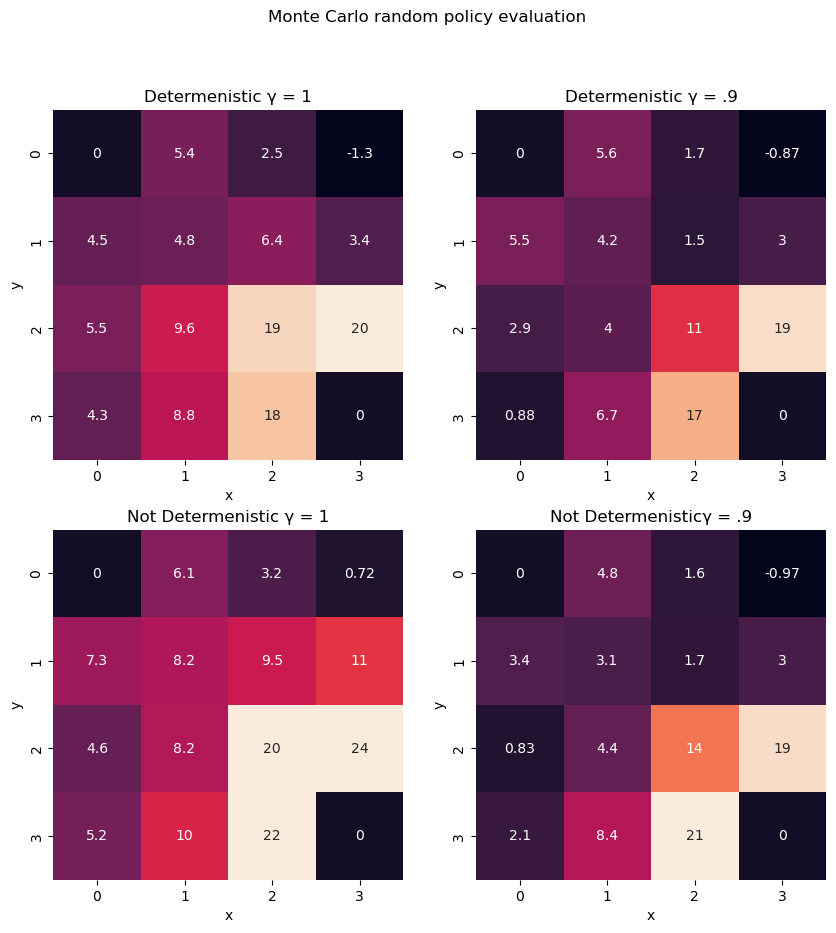

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

# opt_det_labels = easy_dict_to_grid(optimal_policy_determ)
# opt_not_det_labels = easy_dict_to_grid(optimal_policy_determ)

sns.heatmap(det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax1, vmin=-1, vmax=20)
sns.heatmap(det_random_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax2, vmin=-1, vmax=20)
sns.heatmap(not_det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax3, vmin=-1, vmax=20)
sns.heatmap(not_det_random_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax4, vmin=-1, vmax=20)

ax1.set_title(r'Determenistic γ = 1')
ax2.set_title(r'Determenistic γ = .9')
ax3.set_title(r'Not Determenistic γ = 1')
ax4.set_title(r'Not Determenisticγ = .9')
fig.suptitle(r'Monte Carlo random policy evaluation')


What we seems to be quite strange on first sight. The algoritme seems to value the squares in the -10 transfer val zone very high. A possible explenation is that even though the reward of going there is very low it is very close to the finish.

In [31]:
det_optimal_one_discount = easy_dict_to_grid(monte_carlo_policy_evaluation(policy=optimal_policy_determ)).pivot("y", "x", "value")
det_optimal_o_neign_discount = easy_dict_to_grid( monte_carlo_policy_evaluation(discount=0.9, policy=optimal_policy_determ)).pivot("y", "x", "value")
not_det_optimal_one_discount = easy_dict_to_grid(monte_carlo_policy_evaluation(succes_chanse=70, policy=optimal_policy_not_determ)).pivot("y", "x", "value")
not_det_optimal_o_neign_discount = easy_dict_to_grid(monte_carlo_policy_evaluation(discount=0.9, succes_chanse=70, policy=optimal_policy_not_determ)).pivot("y", "x", "value")

100%|██████████| 500/500 [00:00<00:00, 2617.87it/s]
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\2522312360.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  det_optimal_one_discount = easy_dict_to_grid(monte_carlo_policy_evaluation(policy=optimal_policy_determ)).pivot("y", "x", "value")
100%|██████████| 500/500 [00:00<00:00, 2040.83it/s]
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\2522312360.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  det_optimal_o_neign_discount = easy_dict_to_grid( monte_carlo_policy_evaluation(discount=0.9, policy=optimal_policy_determ)).pivot("y", "x", "value")
100%|██████████| 500/500 [00:00<00:00, 2924.07it/s]
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\2522312360.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  not_det_optimal_one_discount = easy_dict_to_grid(monte_c

Text(0.5, 0.98, 'Monte Carlo optimal policy evaluation')

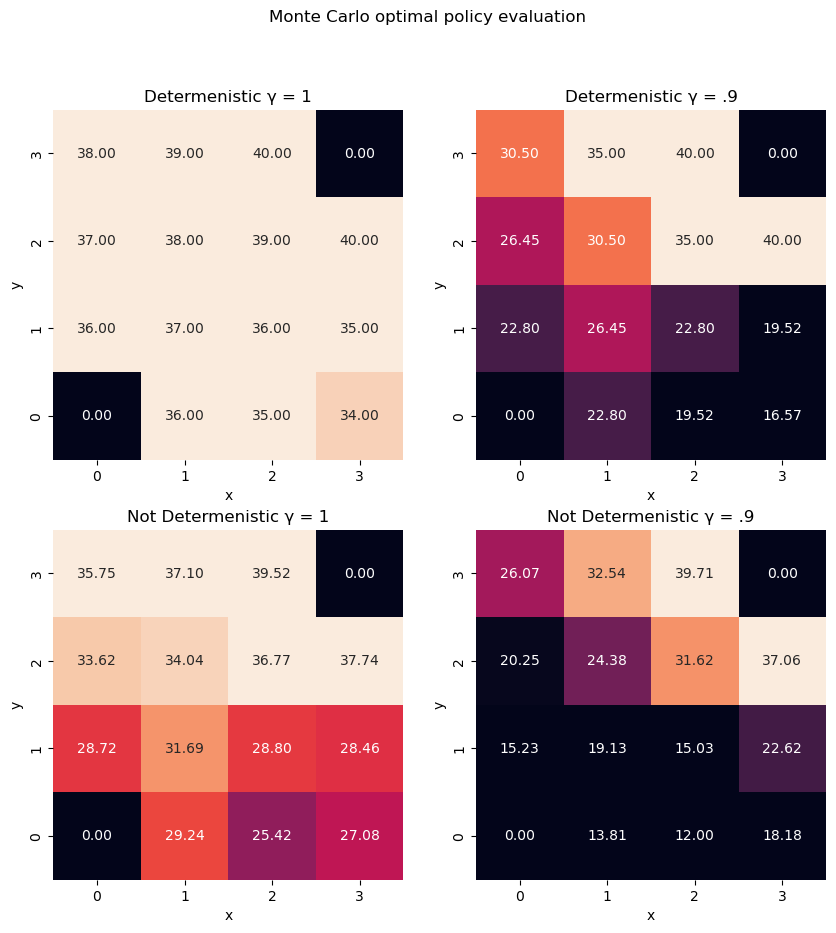

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

sns.heatmap(det_optimal_one_discount, annot=True, square=True, cbar=False, ax=ax1, vmin=20, vmax=35, fmt=".2f")
sns.heatmap(det_optimal_o_neign_discount, annot=True, square=True, cbar=False, ax=ax2, vmin=20, vmax=35, fmt=".2f")
sns.heatmap(not_det_optimal_one_discount, annot=True, square=True, cbar=False, ax=ax3, vmin=20, vmax=35, fmt=".2f")
sns.heatmap(not_det_optimal_o_neign_discount, annot=True, square=True, cbar=False, ax=ax4, vmin=20, vmax=35, fmt=".2f")

ax1.set_title(r'Determenistic γ = 1')
ax1.invert_yaxis()
ax2.set_title(r'Determenistic γ = .9')
ax2.invert_yaxis()
ax3.set_title(r'Not Determenistic γ = 1')
ax3.invert_yaxis()
ax4.set_title(r'Not Determenistic γ = .9')
ax4.invert_yaxis()
fig.suptitle(r'Monte Carlo optimal policy evaluation')

At first I tought that these results where wrong. Aftherall is seems like it values the states in the -10 zone very higly. But this is not the case. Because it uses a optimal policy it doesn't come in that area unless it starts there. And if it starts there than it can go to the end zone very fast. Therefore the action it takes is still of high value. We see that when there is only a 70% chanse that the chosen action actually works that the zones around the "dead zone" take a big hit in their valuation. This is because a wrong action can push them in the "dead zone" while the cells in the "dead zone" do not have this problem. If they take a differnt action than they either get out of the dead zone, the action is invalid (trying to go left) or take one more hit in the dead zone.

I belief that that is also why the right dead zone cell (x=3 y=2) is vieuwed far more favorioblly. Because it can take a invald action and then nothing happens it can simply try again to escape the dead zone.


## Temporal Difference Learning


In [33]:
def tdl(policy, succes_chanse, step_size, discount, n_episodes):
    """Implementation of Temporal Difference Learning"""
    
    state_values = {f"{x}_{y}": 0 for x in range(grid_shape[0]) for y in range(grid_shape[1])}
    for _ in range(n_episodes):
        # get the random first position
        location = state_dict.get(f"{random.randint(0, grid_shape[0] -1)}_{random.randint(0, grid_shape[1] -1)}")
        pos = location.pos
        while pos not in end_states:
            # choose an action based on the policy
            x, y = location.pos.split("_")
            location, reward = step(policy, succes_chanse, x, y)
            
            # update the value of the current_state
            state_values[pos] = state_values[pos] + step_size * (reward + discount * state_values[location.pos] - state_values[pos])
            pos = location.pos
    return state_values   

In [34]:
det_random_one_discount = easy_dict_to_grid(tdl(None, 100, 0.1, 1, 500))
det_random_o_neign_discount = easy_dict_to_grid( tdl(None, 100, 0.1, 0.9, 500))
not_det_random_one_discount = easy_dict_to_grid(tdl(None, 70, 0.1, 1, 500))
not_det_random_o_neign_discount = easy_dict_to_grid(tdl(None, 70, 0.1, 0.9, 500))

C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\842609213.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax1, vmin=-15, vmax=5, fmt=".2f")
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\842609213.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(det_random_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax2, vmin=-15, vmax=5, fmt=".2f")
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\842609213.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(not_det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax3, vmin=-15, vmax=5, fmt=".2f")
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\842609213.py:10: FutureWarning: I

Text(0.5, 0.98, 'Monte Carlo optimal policy evaluation')

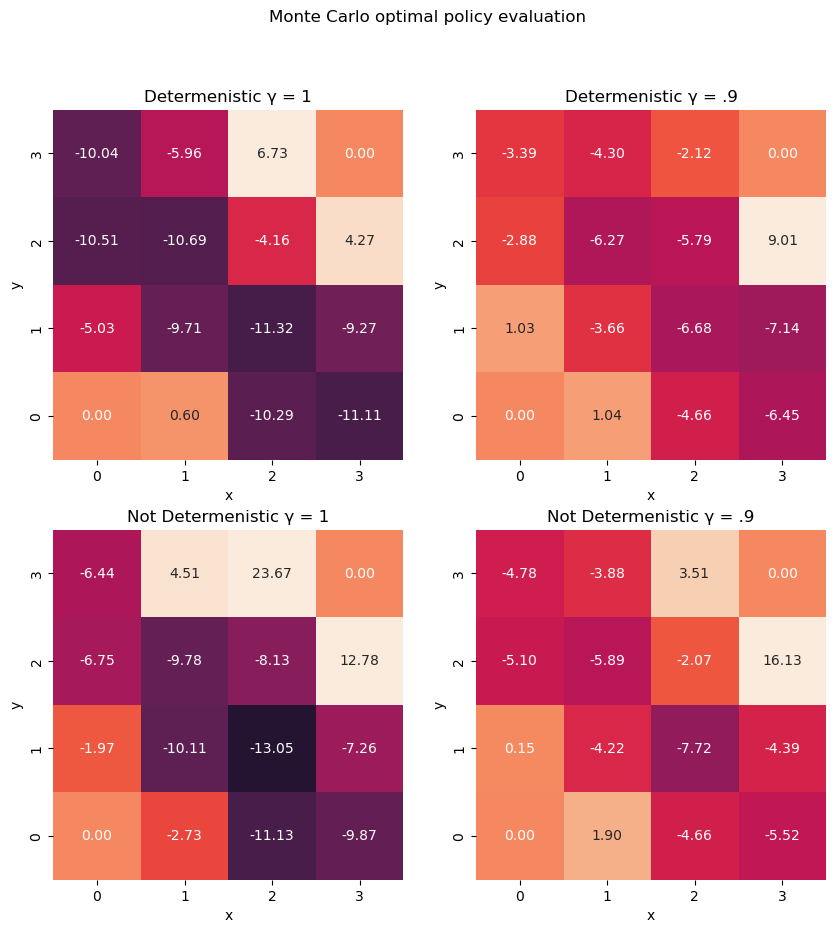

In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

# opt_det_labels = easy_dict_to_grid(optimal_policy_determ)
# opt_not_det_labels = easy_dict_to_grid(optimal_policy_determ)

sns.heatmap(det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax1, vmin=-15, vmax=5, fmt=".2f")
sns.heatmap(det_random_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax2, vmin=-15, vmax=5, fmt=".2f")
sns.heatmap(not_det_random_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax3, vmin=-15, vmax=5, fmt=".2f")
sns.heatmap(not_det_random_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax4, vmin=-15, vmax=5, fmt=".2f")

ax1.set_title(r'Determenistic γ = 1')
ax1.invert_yaxis()
ax2.set_title(r'Determenistic γ = .9')
ax2.invert_yaxis()
ax3.set_title(r'Not Determenistic γ = 1')
ax3.invert_yaxis()
ax4.set_title(r'Not Determenistic γ = .9')
ax4.invert_yaxis()
fig.suptitle(r'Monte Carlo optimal policy evaluation')

In [36]:
det_optimal_one_discount = easy_dict_to_grid(tdl(optimal_policy_determ, 100, 0.1, 1, 200))
det_optimal_o_neign_discount = easy_dict_to_grid( tdl(optimal_policy_determ, 100, 0.1, 0.9, 200))
not_det_optimal_one_discount = easy_dict_to_grid(tdl(optimal_policy_not_determ, 70, 0.1, 1, 200))
not_det_optimal_o_neign_discount = easy_dict_to_grid(tdl(optimal_policy_not_determ, 70, 0.1, 0.9, 200))

C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\3892741713.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(det_optimal_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax1, vmin=-20, vmax=30, fmt=".2f")
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\3892741713.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(det_optimal_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax2, vmin=-20, vmax=30, fmt=".2f")
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\3892741713.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(not_det_optimal_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax3, vmin=-20, vmax=30, fmt=".2f")
C:\Users\lucas\AppData\Local\Temp\ipykernel_22116\3892741713.py:10: Future

Text(0.5, 0.98, 'Monte Carlo optimal policy evaluation')

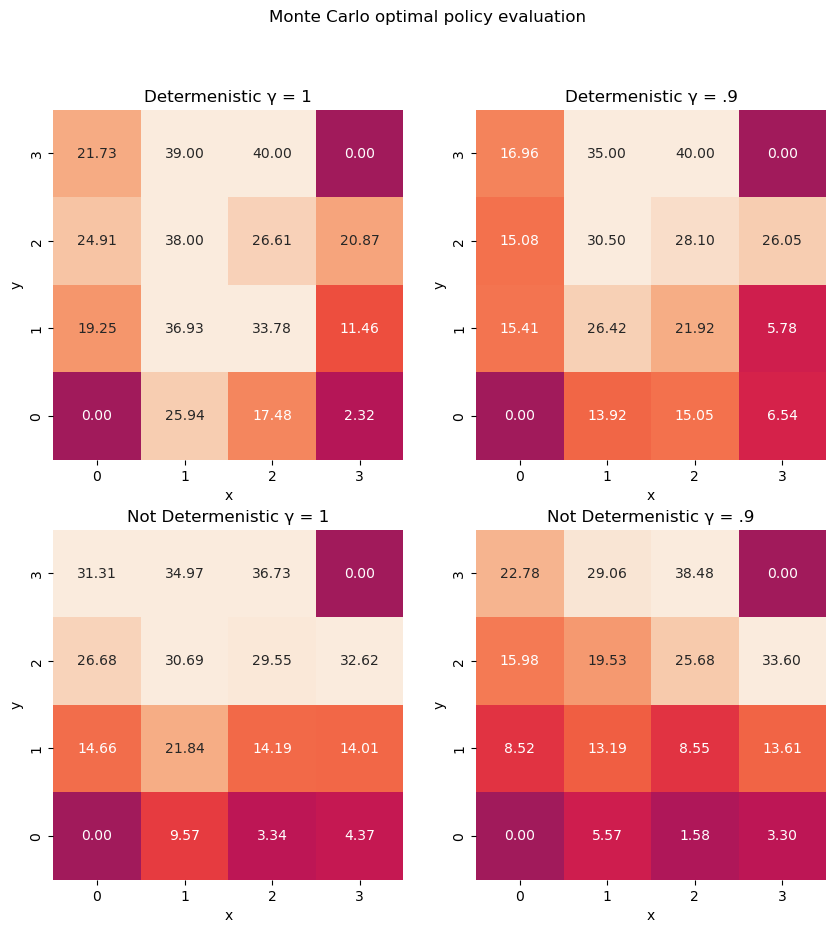

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

# opt_det_labels = easy_dict_to_grid(optimal_policy_determ)
# opt_not_det_labels = easy_dict_to_grid(optimal_policy_determ)

sns.heatmap(det_optimal_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax1, vmin=-20, vmax=30, fmt=".2f")
sns.heatmap(det_optimal_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax2, vmin=-20, vmax=30, fmt=".2f")
sns.heatmap(not_det_optimal_one_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax3, vmin=-20, vmax=30, fmt=".2f")
sns.heatmap(not_det_optimal_o_neign_discount.pivot("y","x", "value"), annot=True, square=True, cbar=False, ax=ax4, vmin=-20, vmax=30, fmt=".2f")

ax1.set_title(r'Determenistic γ = 1')
ax1.invert_yaxis()
ax2.set_title(r'Determenistic γ = .9')
ax2.invert_yaxis()
ax3.set_title(r'Not Determenistic γ = 1')
ax3.invert_yaxis()
ax4.set_title(r'Not Determenistic γ = .9')
ax4.invert_yaxis()
fig.suptitle(r'Monte Carlo optimal policy evaluation')

We see similar resutls to monte carlo. However in the Not determenistic y=.9 it seems to judge the bottom row and (x=2, y=1) more harsly. This makes sense because the bottom row is further from the end goal and has a higher risk using the optimal policy to get in the "dead zone". Aftherall with a optimal policy that risk is purly chanse based and using needing more actions to get to the end statisticly increases the chanses that one of the posible sequences of taken actions end up in the dead zone. But unlike monte carlo given optimal policy in a determanistic setting and a discount of 1 it seems to converege less on the result of value iteration.

## Model free

### Model Free Control

In [38]:
def create_empty_world():
    # Deterministic refers to the implementation of value iteration in the old code. It needs to be set to true so that the code choses the right states
    world = create_maze(deterministic=True)
    for key, value in world.items():
        x, y = key.split("_")
        value.q_table = {}
        if x != "0": 
            value.q_table["Left"] = 0
        if x != "3": 
            value.q_table["Right"] = 0
        if y != "0": 
            value.q_table["Down"] = 0
        if y != "3": 
            value.q_table["Up"] = 0
    return world

def e_greed(world, state, epsilon):
    if epsilon > random.random():
        # exploring
        return random.choice(list(state.q_table.keys()))
    else:
        # If two actions have the same reward. Choses the action/key that first occurs in q_table.keys() 
        return max(state.q_table, key=state.q_table.get)

def apply_action(world, action, x, y):
    # print(action)
    # print(x)
    # print(y)
    if action == "Left":
        state = world.get(f"{int(x)-1}_{y}")
    if action == "Right":
        state = world.get(f"{int(x)+1}_{y}")
    if action == "Up":
        state = world.get(f"{x}_{int(y)+1}")
    if action == "Down":
        state = world.get(f"{x}_{int(y)-1}")

    return state, state.tran_val
    

def sim_episode(succes_chanse, epsilon):
    """ Simulate a single episode following the given policy.
    :param policy: A policy to be followed.
    :return: A list containing the rewards of the episode.
    """
    world = create_empty_world()
    location = world.get(f"{random.randint(0, grid_shape[0] -1)}_{random.randint(0, grid_shape[1] -1)}")
    rewards = []
    vistited_states = []
    taken_actions = []

    while location.pos not in end_states:
        x, y = location.pos.split("_")
        vistited_states.append(location)
        action = e_greed(world, location, epsilon)
        taken_actions.append(action)
        if random.randint(0, 100) > succes_chanse:
            other_actions = ["Left", "Right", "Up", "Down"]
            other_actions.remove(action)
            action = random.choice(other_actions)
        
        reward = get_reward(world, action, x, y)
        rewards.append(reward)
        
    # rewards.append(0)
    # vistited_states.append(location)
    
        
    return vistited_states, rewards, taken_actions

In [39]:
def create_data_list_of_q_table(world):
    data = []
    for key, value in world.items():
        x, y = key.split("_")
        for nested_key, nested_value in value.q_table.items():
            data.append((x, y, nested_key, nested_value))
    return data


def sarsa(n_episodes, epsilon, succes_chanse, step_size, discount, VERBOSE=False):
    world = create_empty_world()
    for counter in range(n_episodes):
        if counter % 100 == 0:
            compare = world.copy()
            compare.pop("0_0")
            compare.pop("3_3")
            df = create_data_list_of_q_table(compare)
            df = pd.DataFrame(df, columns=['x', 'y', 'action', 'value'])
            curr_pol = df.sort_values('value', ascending=False).drop_duplicates(['x','y'])[["x", "y", "action"]].sort_values(["x", "y"]).values
            if np.array_equal(curr_pol, optimal_as_numpy):
                if VERBOSE:
                    print(f"Found optimal policy afhter {counter} episodes")
                return world, counter
                
        
        location = world.get(f"{random.randint(0, grid_shape[0] -1)}_{random.randint(0, grid_shape[1] -1)}")
        chosen_action = e_greed(world, location, epsilon)
        while location.pos not in end_states:
            x, y = location.pos.split("_")
            if random.randint(0, 100) > succes_chanse:
                other_actions = list(location.q_table.keys())
                other_actions.remove(chosen_action)
                action = random.choice(other_actions)
            else:
                action = chosen_action
            
            
            new_location, reward = apply_action(world, action,x, y)
            # print(chosen_action)
            old_value = location.q_table[action]
            #print(old_value)
            next_action = e_greed(world, new_location, epsilon)
            location.q_table[chosen_action] += step_size * (reward + discount * new_location.q_table[next_action] - old_value)

            # update the state and action
            location = new_location
            chosen_action = next_action

    return world, counter

    # Q[(*state, action)] += learning_rate * (reward + (gamma * np.max(Q[next_state[0], next_state[1], :])) - Q[(*state, action)])
    # # update state              
    # state = next_state
    # Q_table[state][action] = Q_table[state][action] + step_size * (reward + discount * Q_table[next_state][next_action] - Q_table[state][action])
            

In [40]:
def show_policy(df):
        """Prints the q-table in a matplotlib figure.
        
        args:
            env (Maze): The environment which holds the rewards of all the possible states.
            q_table (defaultdict): The Q-table with the policy.
        """
        plt.rc('figure', figsize=(12,6))
        arrow_kwargs = {"Up": {"dx": 0.0, "dy": 0.15, "width": 0.02, "x_offset": -0.05, "y_offset": 0.3},
                        "Right": {"dx": 0.15, "dy": 0.0, "width": 0.02, "x_offset": 0.3, "y_offset": 0.0},
                        "Left": {"dx": -0.15, "dy": 0.0, "width": 0.02, "x_offset": -0.4, "y_offset": 0.0},
                        "Down": {"dx": 0.0, "dy": -0.15, "width": 0.02, "x_offset": -0.05, "y_offset": -0.35}}
        
        df = create_data_list_of_q_table(df)
        for data_point in df:
            # set the x and y value for the place of the state in the figure
            x, y = (int(data_point[0]), int(data_point[1]))
            if f"{x}_{y}" in end_states:
                # end state so draw a point
                plt.scatter(x, y, s=40)
            else:
                args = arrow_kwargs[data_point[2]]
                plt.arrow(x, y, dx=args["dx"], dy=args["dy"], width=0.02, color="black")
                plt.text(x + args["x_offset"], y + args["y_offset"], str(round(data_point[3], 2)))
        plt.show()



In [41]:
counters_sarsa_1 = []
for i in range(60):
    returns, counter = sarsa(10000, 0.3, 70, 0.1, 1)
    counters_sarsa_1.append(counter)
print(counters_sarsa_1)
print(np.mean(counters_sarsa_1))

[3100, 5100, 6500, 9500, 7700, 1400, 2300, 2000, 3000, 4600, 1600, 7800, 8200, 2600, 3800, 5400, 5800, 4200, 4100, 1800, 3000, 6200, 6700, 5500, 1900, 9200, 4100, 4400, 3300, 2600, 8600, 9999, 4000, 5800, 7700, 3000, 9999, 9999, 9999, 7200, 2100, 9999, 3600, 9999, 4300, 5300, 3400, 5700, 2000, 7900, 8600, 7600, 3000, 3500, 9999, 5700, 7000, 5100, 9999, 4200]
5544.866666666667


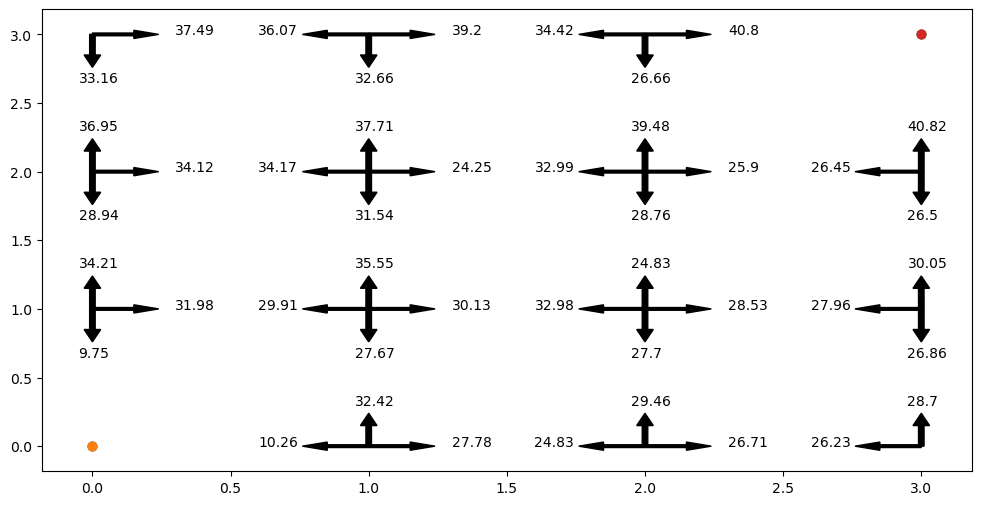

In [42]:
show_policy(returns)

In [43]:
counters_sarsa_0_9 = []
for i in range(60):
    returns, counter = sarsa(10000, 0.3, 70, 0.1, 0.9)
    counters_sarsa_0_9.append(counter)
print(counters_sarsa_0_9)
print(np.mean(counters_sarsa_0_9))

[3500, 3700, 3900, 2300, 2700, 7800, 1600, 5500, 4900, 2300, 2300, 5200, 2300, 7200, 3500, 1500, 2500, 3100, 4500, 8100, 1900, 2300, 1500, 2300, 2800, 3100, 2300, 2700, 2100, 1600, 6600, 2400, 3300, 4600, 1400, 4800, 6100, 3600, 2100, 1200, 5600, 3200, 3100, 1900, 9999, 4800, 2800, 2300, 2800, 1100, 1600, 2100, 3000, 1800, 3000, 3300, 1700, 3000, 1100, 1200]
3274.983333333333


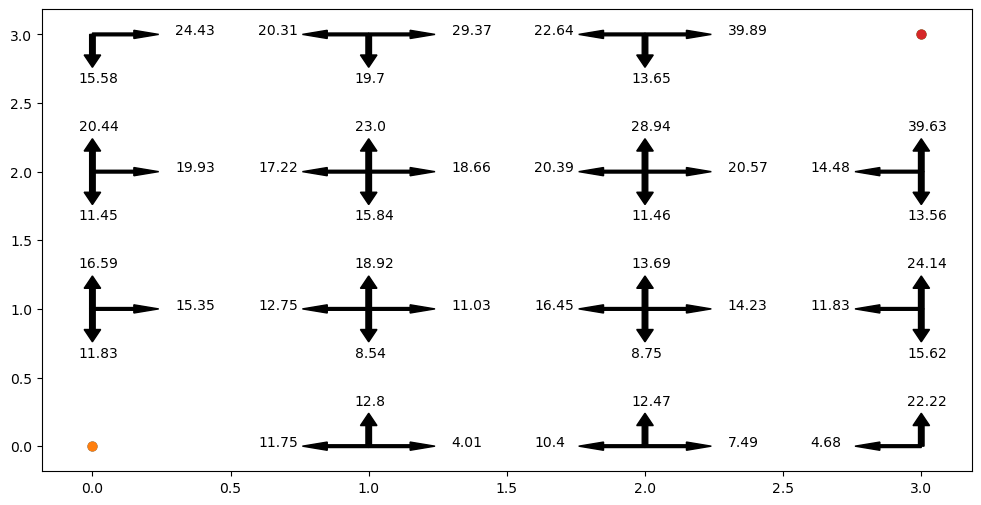

In [44]:
show_policy(returns)

In [45]:
def q_learning(n_episodes, epsilon, succes_chanse, step_size, discount, VERBOSE=False):
    world = create_empty_world()
    for counter in range(n_episodes):
        if counter % 250 == 0:
            compare = world.copy()
            compare.pop("0_0")
            compare.pop("3_3")
            df = create_data_list_of_q_table(compare)
            df = pd.DataFrame(df, columns=['x', 'y', 'action', 'value'])
            curr_pol = df.sort_values('value', ascending=False).drop_duplicates(['x','y'])[["x", "y", "action"]].sort_values(["x", "y"]).values
            if np.array_equal(curr_pol, optimal_as_numpy):
                if VERBOSE:
                    print(f"Found optimal policy afhter {counter} episodes")
                return world, counter
        
        location = world.get(f"{random.randint(0, grid_shape[0] -1)}_{random.randint(0, grid_shape[1] -1)}")
        chosen_action = e_greed(world, location, epsilon)
        while location.pos not in end_states:
            x, y = location.pos.split("_")
            if random.randint(0, 100) > succes_chanse:
                other_actions = list(location.q_table.keys())
                other_actions.remove(chosen_action)
                action = random.choice(other_actions)
            else:
                action = chosen_action
            
            new_location, reward = apply_action(world, action,x, y)
            # print(chosen_action)
            old_value = location.q_table[chosen_action]
            #print(old_value)
            next_action = e_greed(world, new_location, epsilon)
            location.q_table[chosen_action] += step_size * (reward + discount * new_location.q_table[max(new_location.q_table, key=new_location.q_table.get)] - old_value)

            # update the state and action
            location = new_location
            chosen_action = next_action
    return world, counter

In [46]:
q_learning_1 = []
for i in range(60):
    returns, counter = q_learning(10000, 0.3, 70, 0.1, 1)
    q_learning_1.append(counter)
print(q_learning_1)
print(np.mean(q_learning_1))

[3750, 5500, 2750, 1750, 1000, 2000, 8000, 1750, 5250, 2000, 1500, 5500, 3500, 6000, 2000, 7750, 2750, 4750, 1500, 1750, 3250, 2750, 1500, 6500, 5500, 2000, 6750, 2000, 3250, 2750, 2000, 2250, 6500, 6000, 2250, 2250, 4750, 2250, 2000, 5000, 3250, 1750, 5250, 3250, 3750, 5250, 3500, 4500, 3500, 3500, 2500, 5750, 1750, 4750, 9999, 5000, 9999, 1500, 3500, 3250]
3795.8


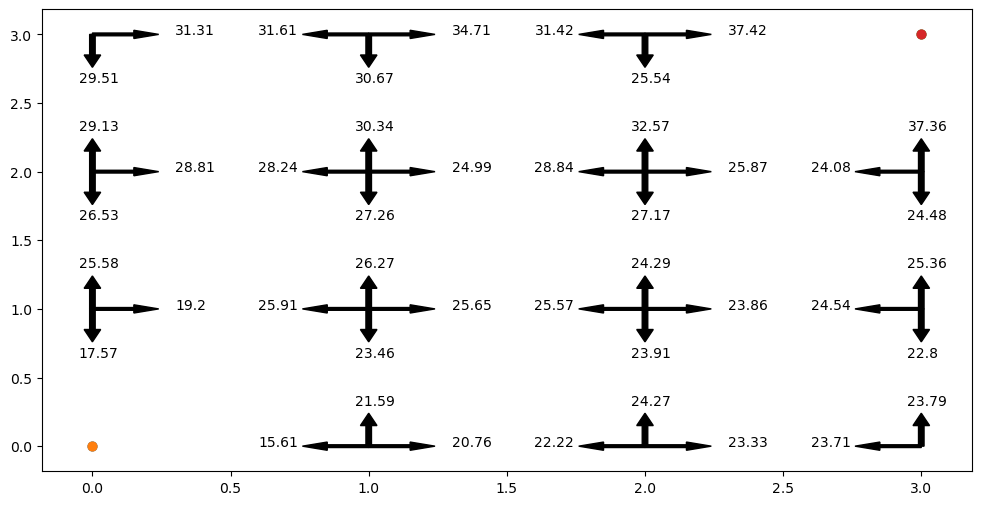

In [47]:
show_policy(returns)

In [48]:
q_learning_0_9 = []
for i in range(60):
    returns, counter = q_learning(10000, 0.3, 70, 0.1, 0.9)
    q_learning_0_9.append(counter)
print(q_learning_0_9)
print(np.mean(q_learning_0_9))

[9999, 4250, 9750, 2500, 2250, 9999, 9999, 9999, 4000, 3500, 7000, 9999, 9999, 3250, 1750, 3000, 9999, 7250, 9999, 4000, 5250, 3750, 4250, 8250, 9999, 9999, 9999, 8000, 8250, 5250, 1750, 9999, 3750, 9999, 9999, 4500, 9999, 9999, 6750, 5000, 9999, 9999, 9999, 9999, 2500, 8750, 9999, 9999, 9999, 9999, 9999, 5250, 8500, 4500, 4000, 9999, 9999, 9999, 8500, 9999]
7487.016666666666


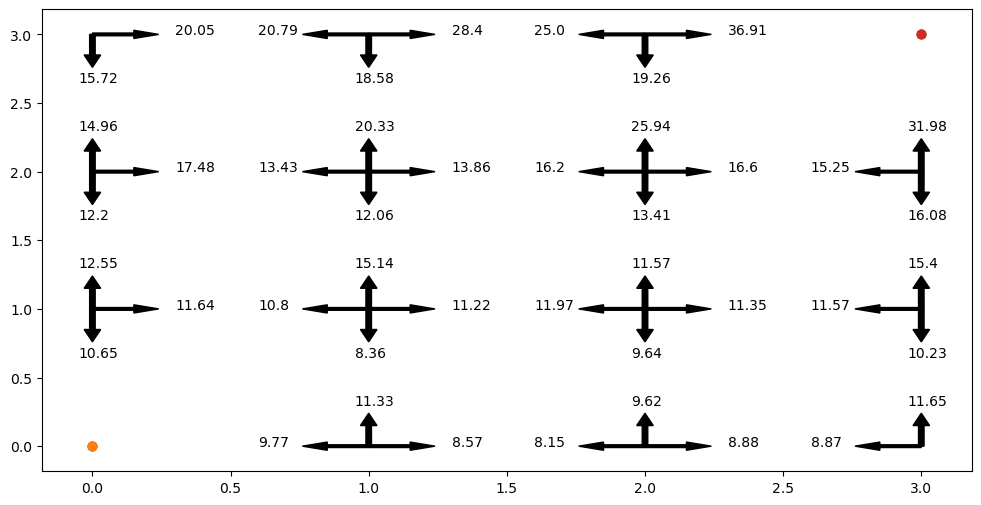

In [49]:
show_policy(returns)

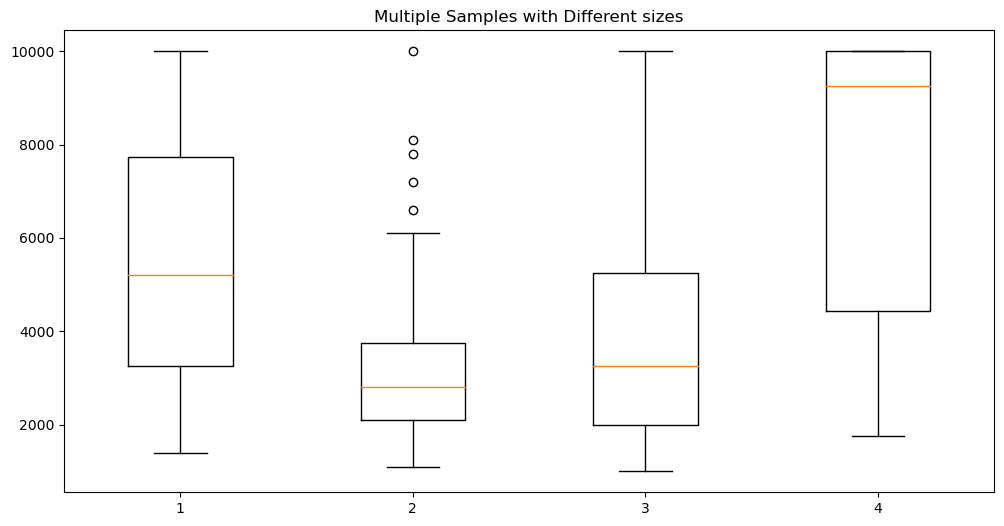

In [50]:
fig, ax = plt.subplots()
ax.set_title('Multiple Samples with Different sizes')
ax.boxplot([counters_sarsa_1, counters_sarsa_0_9, q_learning_1, q_learning_0_9])

plt.show()